In [1]:
from opal import load_dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sampler_check import *

from pyOPALTools.surrogate.uqtk_model import UQTk as UQ
from pyOPALTools.surrogate.chaospy_model import UQChaospy as CH

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
save_figures = False

fig_path = './figures5/'

------------------------

# Define some useful functions

In [3]:
def train_test(x,y):
    xtrain=[]
    ytrain=[]
    xtest= []
    ytest= []

    for ydata in y:
        x_train, x_test, y_train, y_test = train_test_split(x, ydata, test_size=0.2, random_state=42)
        xtrain.append(x_train)
        ytrain.append(y_train)
        xtest.append(x_test)
        ytest.append(y_test)

    return xtrain, ytrain, xtest, ytest;

In [4]:
def create_model(xtrain, ytrain, xtest, n_qoi, pol_order):

    uq = []
    yhat_train = []
    yhat_test = []
    sens_t = []
    sens_m = []
    
    for i in range(n_qoi):

        model = None

        model = UQ(pdom, order=pol_order, method='lsq')

        model.fit(xtrain[i], ytrain[i])

        uq.append(model)

        yhat_train.append(model.predict(xtrain[i]))

        yhat_test.append(model.predict(xtest[i]))

        sens_t.append(model.total_sensitivity())
        sens_m.append(model.main_sensitivity())
        
    return uq, yhat_train, yhat_test, sens_m, sens_t

In [5]:
def fit_eval(y, ytrain, ytest, yhat_train, yhat_test, labels, hat, savename=None, save=False):
    
    # Fit plots
    
    for i in range(len(y)):
        plt.figure(figsize=(5,5))
        line = np.linspace(min(y[i]), max(y[i]), 10)
        plt.scatter(ytrain[i], yhat_train[i], s=3, c='b')
        plt.scatter(ytest[i], yhat_test[i], s=3, c='r')
        plt.xlabel(labels[i], fontsize=19)
        plt.ylabel(hat[i], fontsize=19)
        plt.ticklabel_format(axis='both', style='sci',scilimits=(0,0), useMathText=True)
        plt.plot(line, line, 'g--')
        plt.legend(['$\hat{y}=y$','Training data', 'Testing data'], fontsize=12)
        if save:
            plt.savefig(fig_path+savename[i]+'_fit.pdf', dpi=500, bbox_inches = "tight")
        plt.show()
        
    # Rsquared values
    
    Rsquared = []
    
    for j in range(len(y)):
        SSt = 0
        SSres = 0

        for i,num in enumerate(ytrain[j]):
            SSt = SSt + (num-np.mean(ytrain[j]))**2
            SSres = SSres + (ytrain[j][i] - yhat_train[j][i])**2

        R= 1-SSres/SSt
        Rsquared.append(R)
        
    # Errors
    
    mae_test = []
    mse_test = []
    mae_train = []
    mse_train = []

    for i, data in enumerate(ytest):
        mae_test.append(100*mean_absolute_error(data, yhat_test[i])/np.mean(data))
        mse_test.append(100*mean_squared_error(data, yhat_test[i])/np.mean(data))

    for i, data in enumerate(ytrain):
        mae_train.append(100*mean_absolute_error(data, yhat_train[i])/np.mean(data))
        mse_train.append(100*mean_squared_error(data, yhat_train[i])/np.mean(data))

    errors = pd.DataFrame(list(zip(mae_train, mae_test, mse_train, mse_test)), index =labels,
                           columns = ['MAE train', 'MAE test', 'MSE train', 'MSE test'])

    
    return Rsquared, errors

In [6]:
# Function that sets up the sobol indices for the sensitivity analysis bar plots

def bar_plot(sens_m, sens_t, n_var, n_qoi):

    sm = []
    st = []

    for i in range(n_var):
        sim = []
        sit = []
        for j in range(n_qoi):
            sim.append(sens_m[j][i])
            sit.append(sens_t[j][i])
        sm.append(sim)
        st.append(sit)

    bottom_m = []
    bottom_t = []

    for i in range(n_var):

        add_m = [0]*n_qoi
        add_t = [0]*n_qoi

        for j in range(i):
            add_m = [add_m[k] + sm[j][k] for k in range(len(sm[j]))]
            add_t = [add_t[k] + st[j][k] for k in range(len(st[j]))]
            
        bottom_m.append(add_m)
        bottom_t.append(add_t)

    return sm, st, bottom_m, bottom_t

In [7]:
def sensitivity_plot(sens_m, sens_t, n_var, n_qoi, label_dvar, labels, savename='sens', save=False, print_legend=True):
    
    ind = np.linspace(0,n_qoi*2, n_qoi, endpoint=False)
    width = 1.3

    sm, st, bottom_m, bottom_t = bar_plot(sens_m, sens_t, n_var, n_qoi)

    pt = []
    
    plt.figure(figsize=(6,5))
    
    for i in range(n_var):
        pi = plt.bar(ind, st[i], width, bottom = bottom_t[i])
        pt.append(pi)

    plt.ylabel('Total Sensitivity', fontsize=15)
    plt.xticks(ind, labels, fontsize=16)
    plt.xlim(-0.65,ind[-1]+0.65)
    leg = []
    for i in range(n_var):
        leg.append(pt[i][0])
    
    if print_legend:
        plt.legend(leg, label_dvar, bbox_to_anchor=(1, 1.05), fontsize=14)
    
    if save:
        plt.savefig(fig_path + savename + '.pdf', dpi=500, bbox_inches = "tight")

    plt.show()

------------------------

# Load the json file with the design variables + objectives data

In [8]:
# number of turns in simulation
turns=95

# path where the sampler has created the output files - initial simulation
path = '/data/project/general/isodarUQ/1000_6_95_uniform_numPart/output/'

# load the .json file, which contains design variable & objectives information
sampler = load_dataset(path, fname = 'IsoDAR60MeV_samples_0.json')

print(sampler)


	Sampler dataset.

	Number of samplers:  1

	Number of samples: 1000 per generation 

	Available design variables (6) :

	pr0                 
	r0                  
	rfphi               
	sigmax              
	sigmay              
	sigmaz              

	Available objectives (10) :

	EMIT_S              
	EMIT_X              
	EMIT_Y              
	HALO_X              
	HALO_Y              
	HALO_Z              
	NUM_PART            
	RMS_S               
	RMS_X               
	RMS_Y               



In [9]:
# path where the sampler has created the output files - additional simulations for importance sampling
path2 = '/data/project/general/isodarUQ/1000_6_95_uniform_importanceSampling/output/'

# load the .json file, which contains design variable & objectives information
sampler2 = load_dataset(path2, fname = 'IsoDAR60MeV_samples_0.json')

print(sampler2)


	Sampler dataset.

	Number of samplers:  1

	Number of samples: 1000 per generation 

	Available design variables (6) :

	pr0                 
	r0                  
	rfphi               
	sigmax              
	sigmay              
	sigmaz              

	Available objectives (10) :

	EMIT_S              
	EMIT_X              
	EMIT_Y              
	HALO_X              
	HALO_Y              
	HALO_Z              
	NUM_PART            
	RMS_S               
	RMS_X               
	RMS_Y               



In [10]:
# path where the sampler has created the output files - additional simulations for importance sampling
path3 = '/data/project/general/isodarUQ/500_6_95_uniform_importanceSampling/output/'

# load the .json file, which contains design variable & objectives information
sampler3 = load_dataset(path3, fname = 'IsoDAR60MeV_samples_0.json')

print(sampler3)


	Sampler dataset.

	Number of samplers:  1

	Number of samples: 500 per generation 

	Available design variables (6) :

	pr0                 
	r0                  
	rfphi               
	sigmax              
	sigmay              
	sigmaz              

	Available objectives (10) :

	EMIT_S              
	EMIT_X              
	EMIT_Y              
	HALO_X              
	HALO_Y              
	HALO_Z              
	NUM_PART            
	RMS_S               
	RMS_X               
	RMS_Y               



In [11]:
# path where the sampler has created the output files - add the 5000 uniformly sampled simulations
path4 = '/data/user/mayani_s/5000_6_95_uniform/output/'

# load the .json file, which contains design variable & objectives information
sampler4 = load_dataset(path4, fname = 'IsoDAR60MeV_samples_0.json')

print(sampler4)


	Sampler dataset.

	Number of samplers:  1

	Number of samples: 5000 per generation 

	Available design variables (6) :

	pr0                 
	r0                  
	rfphi               
	sigmax              
	sigmay              
	sigmaz              

	Available objectives (9) :

	EMIT_S              
	EMIT_X              
	EMIT_Y              
	HALO_X              
	HALO_Y              
	HALO_Z              
	RMS_S               
	RMS_X               
	RMS_Y               



In [12]:
N1 = sampler.size


# Create a dataframe that contains the values for each design variable

names_dvar = sampler.design_variables
n_var = len(names_dvar)

dvars1 = pd.DataFrame(columns=names_dvar)

for i in range(N1):
    dvars1 = dvars1.append(sampler.getData(var='', ind= i), ignore_index=True)
    
label_dvar = ['$p_{r0}$ [$\\beta\gamma$]', '$r_0$ [mm]', '$\phi_{RF}$ [deg]',
              '$\sigma_x$ [m]', '$\sigma_y$ [m]', '$\sigma_z$ [m]']


# Domain of interest of the design variables (can be obtained from sampler.bounds)
pdom =np.array([[2.254e-03, 1.159e+02, 2.830e+02, 9.500e-04, 2.850e-03, 4.750e-03],
                [2.346e-03, 1.199e+02, 2.870e+02, 1.050e-03, 3.150e-03, 5.250e-03]])


# Create a list that contains the values for each objective

names_qoi = ['EMIT_X', 'EMIT_Y', 'EMIT_S', 'HALO_X', 'HALO_Y', 'HALO_Z', 'RMS_X','RMS_Y', 'RMS_S']
n_qoi = len(names_qoi)

In [13]:
labels = ['$\epsilon_x$', '$\epsilon_y$', '$\epsilon_z$', '$h_x$', '$h_y$', '$h_z$',
          '$\sigma_x$', '$\sigma_y$', '$\sigma_z$']

labels_units = ['$\epsilon_x$ [mm$\cdot$mrad]', '$\epsilon_y$ [mm$\cdot$mrad]', '$\epsilon_z$ [mm$\cdot$mrad]', '$h_x$ [-]',
                '$h_y$  [-]', '$h_z$ [-]', '$\sigma_x$ [m]', '$\sigma_y$ [m]', '$\sigma_z$ [m]']

hat = ['$\hat{\epsilon_x}$ [mm$\cdot$mrad]', '$\hat{\epsilon_y}$ [mm$\cdot$mrad]', '$\hat{\epsilon_z}$ [mm$\cdot$mrad]',
       '$\hat{h_x}$ [-]','$\hat{h_y}$  [-]', '$\hat{h_z}$ [-]',
       '$\hat{\sigma_x}$ [m]', '$\hat{\sigma_y}$ [m]', '$\hat{\sigma_z}$ [m]']


y1 = []
idx1 = []

for name in names_qoi:    
    for i in range(N1):
        obj = float(sampler.getData(var=name, ind=i))
        
        # remove infs from the objectives, and for the emittances, remove too small emittances (<1e-8)
        
        if name[0:4]=='EMIT':
            if (obj == float('inf')) or (obj < 1e-08):
                if i not in idx1:
                    idx1.append(i)
        else:
            if (obj == float('inf')):
                if i not in idx1:
                    idx1.append(i)                    

for name in names_qoi: 
    
    ydata = []
    
    for i in range(N1):
        obj = float(sampler.getData(var=name, ind=i))
        
        if i not in idx1:
            ydata.append(obj)
            
    print(len(ydata))
    
    y1.append(ydata)
    
    
N1 = N1 - len(idx1)


dvars1.drop(list(idx1), inplace=True)


print(len(dvars1))

987
987
987
987
987
987
987
987
987
987


In [14]:
N2 = sampler2.size

dvars2 = pd.DataFrame(columns=names_dvar)

for i in range(N2):
    dvars2 = dvars2.append(sampler2.getData(var='', ind= i), ignore_index=True)
    
y2 = []
idx2 = []

for name in names_qoi:    
    for i in range(N2):
        obj = float(sampler2.getData(var=name, ind=i))
        
        # remove infs from the objectives, and for the emittances, remove too small emittances (<1e-8)
        
        if name[0:4]=='EMIT':
            if (obj == float('inf')) or (obj < 1e-08):
                if i not in idx2:
                    idx2.append(i)
        else:
            if (obj == float('inf')):
                if i not in idx2:
                    idx2.append(i)                    

for name in names_qoi: 
    
    ydata = []
    
    for i in range(N2):
        obj = float(sampler2.getData(var=name, ind=i))
        
        if i not in idx2:
            ydata.append(obj)
            
    print(len(ydata))
    
    y2.append(ydata)
    
    
N2 = N2 - len(idx2)


dvars2.drop(list(idx2), inplace=True)

print(len(dvars2))

995
995
995
995
995
995
995
995
995
995


In [15]:
N3 = sampler3.size

dvars3 = pd.DataFrame(columns=names_dvar)

for i in range(N3):
    dvars3 = dvars3.append(sampler3.getData(var='', ind= i), ignore_index=True)
    
y3 = []
idx3 = []

for name in names_qoi:    
    for i in range(N3):
        obj = float(sampler3.getData(var=name, ind=i))
        
        # remove infs from the objectives, and for the emittances, remove too small emittances (<1e-8)
        
        if name[0:4]=='EMIT':
            if (obj == float('inf')) or (obj < 1e-08):
                if i not in idx3:
                    idx3.append(i)
        else:
            if (obj == float('inf')):
                if i not in idx3:
                    idx3.append(i)                    

for name in names_qoi: 
    
    ydata = []
    
    for i in range(N3):
        obj = float(sampler3.getData(var=name, ind=i))
        
        if i not in idx3:
            ydata.append(obj)
            
    print(len(ydata))
    
    y3.append(ydata)
    
    
N3 = N3 - len(idx3)


dvars3.drop(list(idx3), inplace=True)

print(len(dvars3))

497
497
497
497
497
497
497
497
497
497


In [16]:
N4 = sampler4.size

dvars4 = pd.DataFrame(columns=names_dvar)

for i in range(N4):
    dvars4 = dvars4.append(sampler4.getData(var='', ind= i), ignore_index=True)
    
y4 = []
idx4 = []

for name in names_qoi:    
    for i in range(N4):
        obj = float(sampler4.getData(var=name, ind=i))
        
        # remove infs from the objectives, and for the emittances, remove too small emittances (<1e-8)
        
        if name[0:4]=='EMIT':
            if (obj == float('inf')) or (obj < 1e-08):
                if i not in idx2:
                    idx4.append(i)
        else:
            if (obj == float('inf')):
                if i not in idx4:
                    idx4.append(i)                    

for name in names_qoi: 
    
    ydata = []
    
    for i in range(N4):
        obj = float(sampler4.getData(var=name, ind=i))
        
        if i not in idx4:
            ydata.append(obj)
            
    print(len(ydata))
    
    y4.append(ydata)
    
    
N4 = N4 - len(idx4)


dvars4.drop(list(idx4), inplace=True)

print(len(dvars4))

4927
4927
4927
4927
4927
4927
4927
4927
4927
4927


In [17]:
# Merge the two datasets (initial simulations + simulations for importance sampling)

N = N1 + N2 + N3 + N4
print(N)

frames = [dvars1, dvars2, dvars3, dvars4]
dvars = pd.concat(frames)

print(len(dvars))

y = []

for i in range(n_qoi):
    y.append(y1[i] + y2[i] + y3[i] + y4[i])
    
print(len(y[0]))

7260
7406
7406


In [18]:
x = np.vstack(dvars.to_numpy())

In [19]:
names_qoi = ['EMIT_X', 'EMIT_Y', 'EMIT_Z', 'HALO_X', 'HALO_Y', 'HALO_Z', 'RMS_X','RMS_Y', 'RMS_Z']

In [20]:
# Scaled vector with just the emittances multiplied by 10^6 to change units to mm mrad: 

yunit = []

for i in range(n_qoi):
    if names_qoi[i][0:4]=='EMIT':
        
        new_y = []
        
        for j in range(len(y[0])):
            new_y.append(y[i][j]*1e6)
            
        yunit.append(new_y)
        
    else:
        yunit.append(y[i])
        

------------------------

# Histogram of the outputs in order to see whether they make physical sense

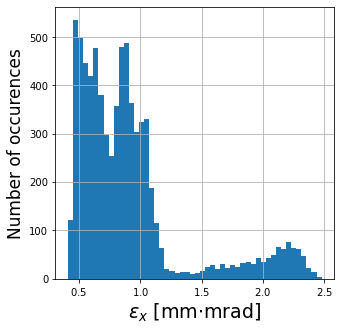

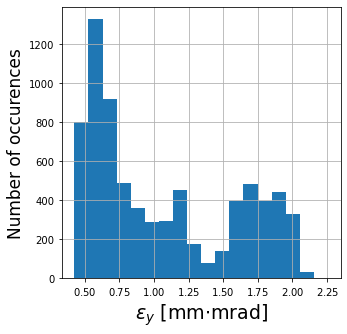

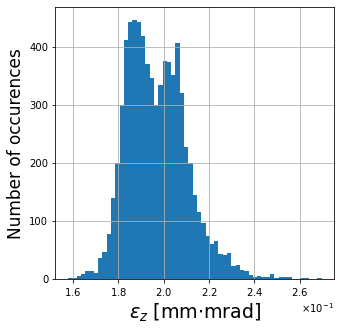

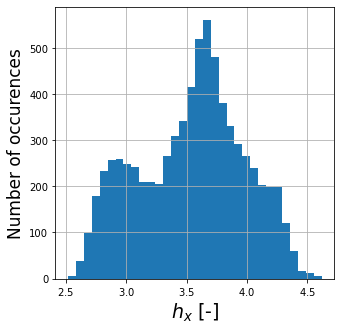

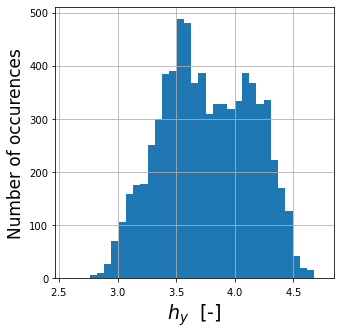

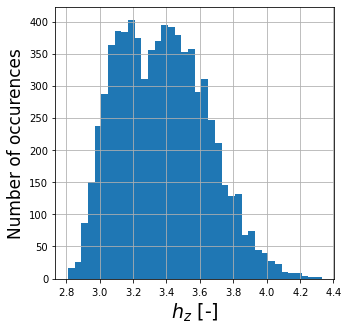

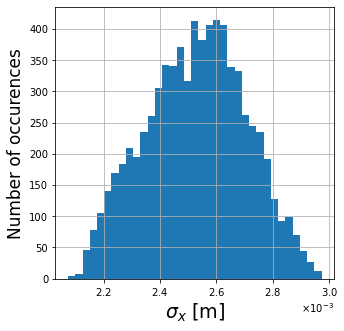

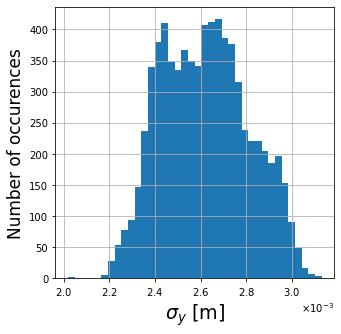

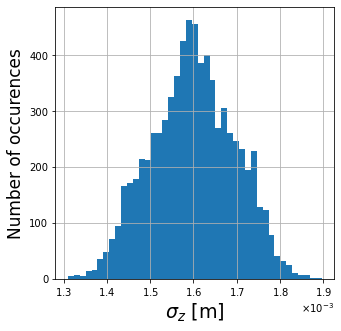

In [21]:
for i in range(n_qoi):
    plt.figure(figsize=(5,5))
    plt.hist(yunit[i], bins='auto')
    plt.ticklabel_format(axis='x', style='sci',scilimits=(0,0), useMathText=True)
    plt.xlabel(labels_units[i], fontsize=19)
    plt.ylabel('Number of occurences', fontsize=17)
    if save_figures:
        plt.savefig(fig_path + 'hist_'+names_qoi[i]+'.pdf', dpi = 500, bbox_inches = "tight")
    plt.grid()
    plt.show()

------------------------

# Surrogate model

In [22]:
xtrain, ytrain, xtest, ytest = train_test(x, yunit)

### UQTk model

In [23]:
uq6, yhat_train6, yhat_test6, sm6, st6 = create_model(xtrain, ytrain, xtest, n_qoi, 6)

### How good is the fit?

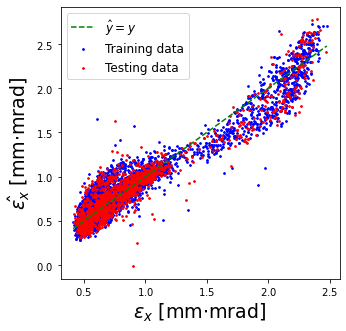

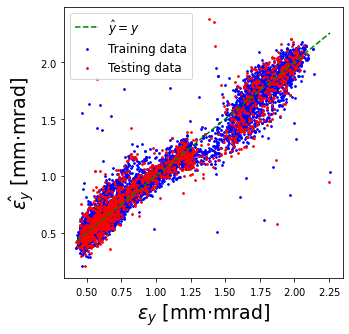

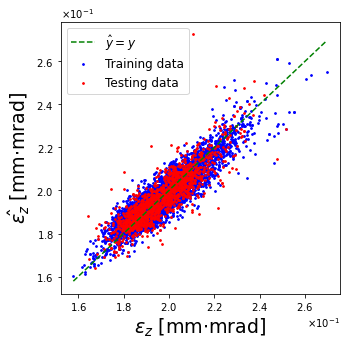

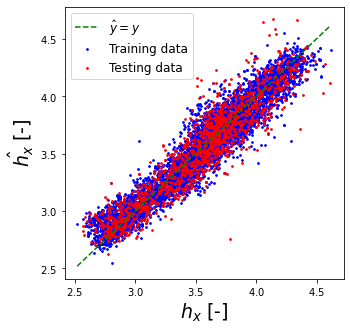

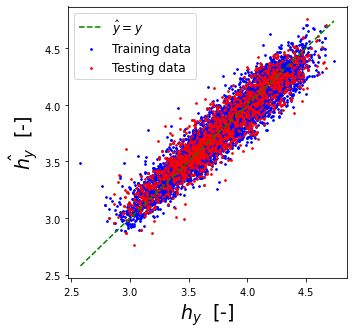

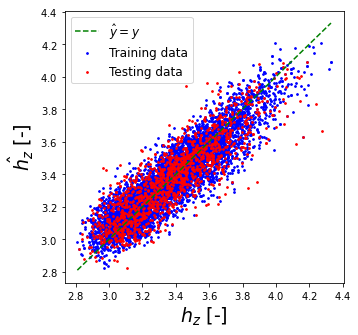

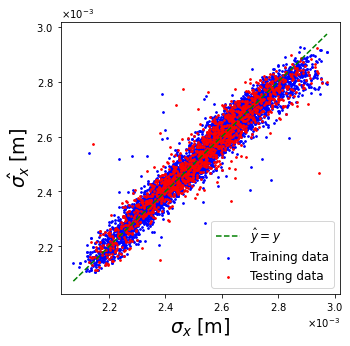

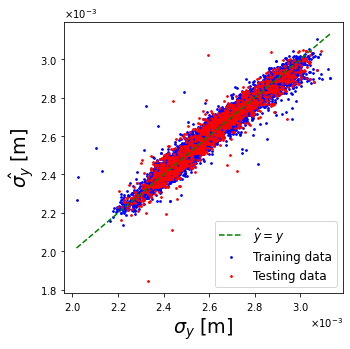

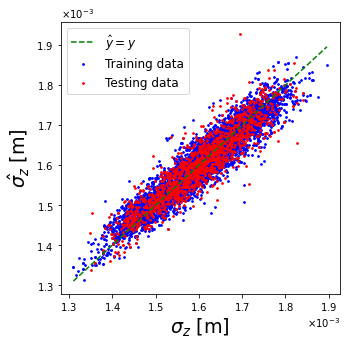

In [24]:
Rsquared6, errors6 = fit_eval(yunit, ytrain, ytest, yhat_train6, yhat_test6, labels_units, hat,
                              savename=names_qoi, save=save_figures)

In [25]:
print(Rsquared6)

[0.9271147846081993, 0.9483594566300954, 0.8397223932156842, 0.9165825259478887, 0.9026096535817052, 0.8165255383716064, 0.9447570154724189, 0.9461312602890932, 0.8878155230196475]


In [26]:
errors6

,MAE train,MAE test,MSE train,MSE test
$\epsilon_x$ [mm$\cdot$mrad],9.397187,11.643873,1.656684,2.518823
$\epsilon_y$ [mm$\cdot$mrad],7.621135,9.097649,1.303269,1.967924
$\epsilon_z$ [mm$\cdot$mrad],2.065314,2.378235,0.014169,0.020738
$h_x$ [-],2.776718,3.372337,0.451540,0.683593
$h_y$ [-],2.477438,2.968650,0.381481,0.543995
$h_z$ [-],2.635573,3.027616,0.379821,0.522906
$\sigma_x$ [m],1.221384,1.521169,0.000068,0.000112
$\sigma_y$ [m],1.250924,1.521905,0.000074,0.000115
$\sigma_z$ [m],1.571111,1.760405,0.000065,0.000085


------------

# Sensitivity analysis

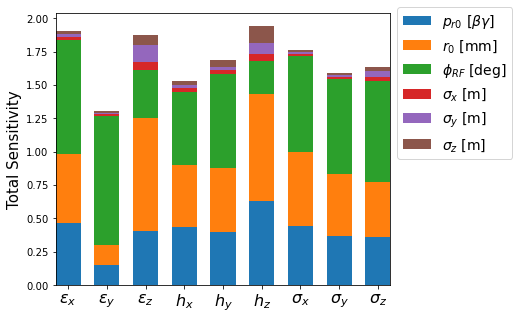

In [27]:
# ORDER 6

sensitivity_plot(sm6, st6, n_var, n_qoi, label_dvar, labels, savename='sens6', save=save_figures, print_legend=True)

------------

# MAE vs. order (from 1 to 7) plots

In [28]:
uq1, yhat_train1, yhat_test1, sm1, st1 = create_model(xtrain, ytrain, xtest, n_qoi, 1)
uq2, yhat_train2, yhat_test2, sm2, st2 = create_model(xtrain, ytrain, xtest, n_qoi, 2)
uq3, yhat_train3, yhat_test3, sm3, st3 = create_model(xtrain, ytrain, xtest, n_qoi, 3)
uq4, yhat_train4, yhat_test4, sm4, st4 = create_model(xtrain, ytrain, xtest, n_qoi, 4)
uq5, yhat_train5, yhat_test5, sm5, st5 = create_model(xtrain, ytrain, xtest, n_qoi, 5)
uq7, yhat_train7, yhat_test7, sm7, st7 = create_model(xtrain, ytrain, xtest, n_qoi, 7)

In [29]:
%%capture

Rsquared1, errors1 = fit_eval(yunit, ytrain, ytest, yhat_train1, yhat_test1, labels_units, hat)

In [30]:
%%capture

Rsquared2, errors2 = fit_eval(yunit, ytrain, ytest, yhat_train2, yhat_test2, labels_units, hat)

In [31]:
%%capture 

Rsquared3, errors3 = fit_eval(yunit, ytrain, ytest, yhat_train3, yhat_test3, labels_units, hat)

In [32]:
%%capture

Rsquared4, errors4 = fit_eval(yunit, ytrain, ytest, yhat_train4, yhat_test4, labels_units, hat)

In [33]:
%%capture

Rsquared5, errors5 = fit_eval(yunit, ytrain, ytest, yhat_train5, yhat_test5, labels_units, hat)

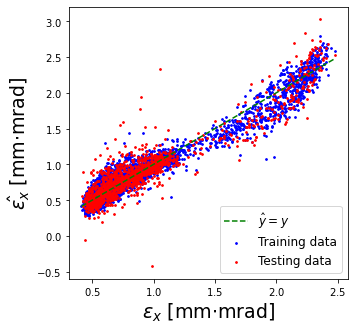

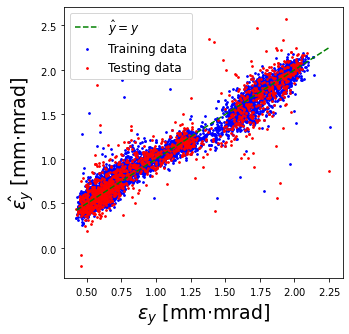

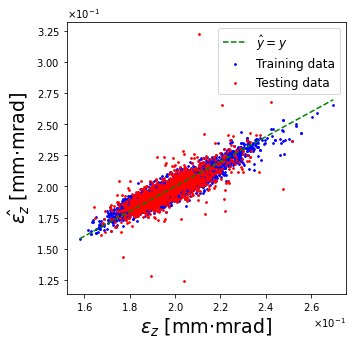

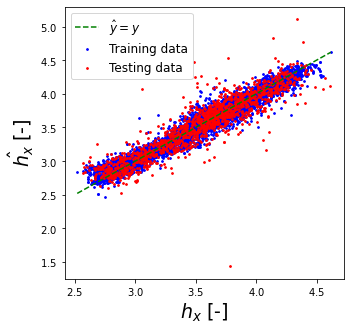

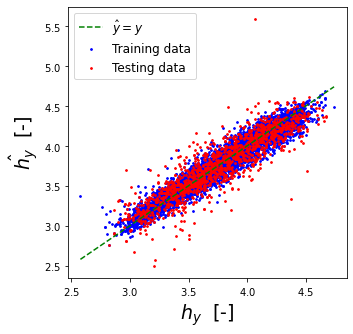

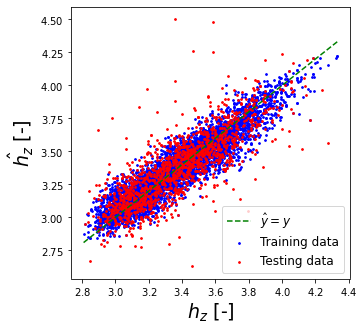

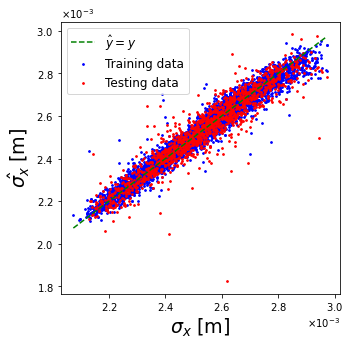

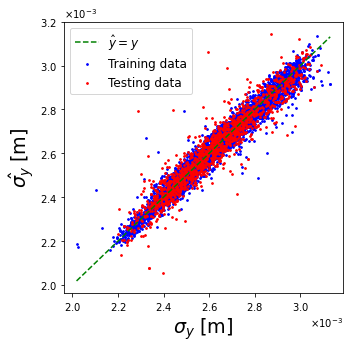

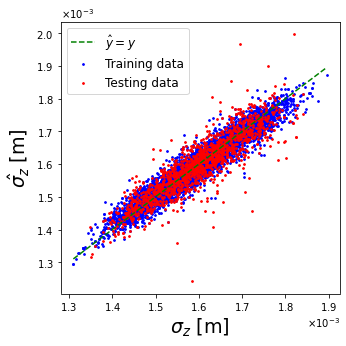

In [34]:
#%%capture

Rsquared7, errors7 = fit_eval(yunit, ytrain, ytest, yhat_train7, yhat_test7, labels_units, hat)

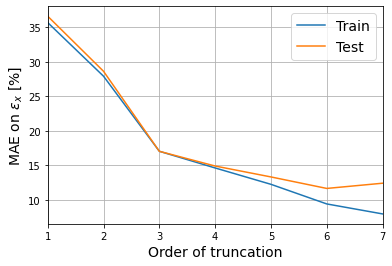

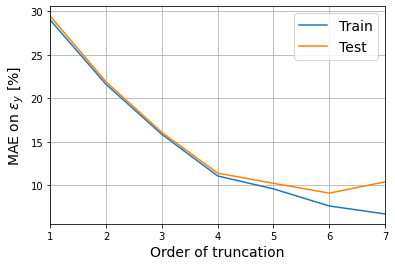

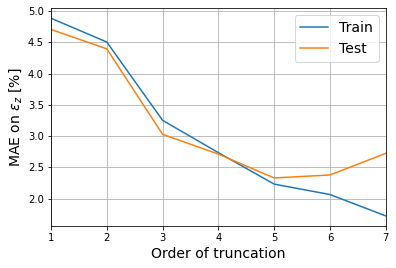

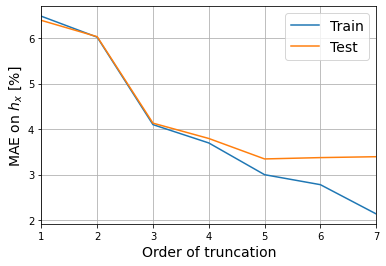

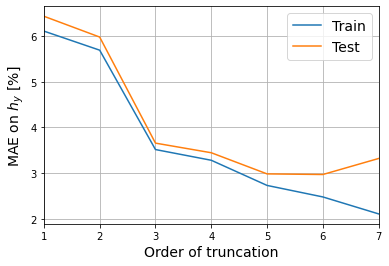

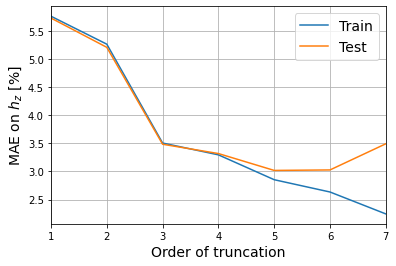

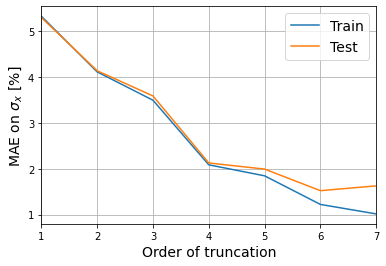

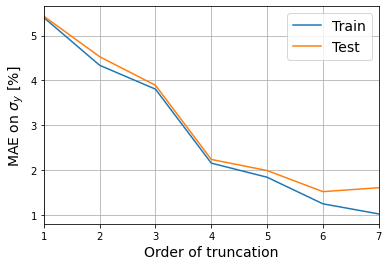

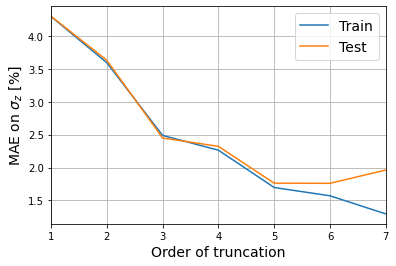

In [35]:
orders = [1,2,3,4,5,6,7]

for i in range(n_qoi):
    err_test = [errors1.iloc[i][1], errors2.iloc[i][1], errors3.iloc[i][1], errors4.iloc[i][1], errors5.iloc[i][1],
               errors6.iloc[i][1], errors7.iloc[i][1]]
    err_train = [errors1.iloc[i][0], errors2.iloc[i][0], errors3.iloc[i][0], errors4.iloc[i][0], errors5.iloc[i][0],
                errors6.iloc[i][0], errors7.iloc[i][0]]

    plt.plot(orders, err_train)
    plt.plot(orders, err_test)
    plt.xlabel('Order of truncation', fontsize=14)
    plt.xlim(1,7)
    plt.ylabel('MAE on '+labels[i]+' [%]', fontsize=14)
    plt.legend(['Train', 'Test'], fontsize=14)
    plt.grid()
    if save_figures:
        plt.savefig(fig_path+'ordervsmae'+names_qoi[i]+'.pdf', dpi=500, bbox_inches = "tight")
    plt.show()

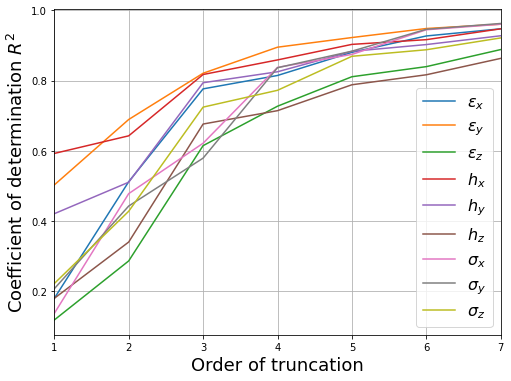

In [36]:
order=[1,2,3,4,5,6,7]
r2 = []

for i in range(n_qoi):
    r2i = []
    r2i.append(Rsquared1[i])
    r2i.append(Rsquared2[i])
    r2i.append(Rsquared3[i])
    r2i.append(Rsquared4[i])
    r2i.append(Rsquared5[i])
    r2i.append(Rsquared6[i])
    r2i.append(Rsquared7[i])
    
    r2.append(r2i)
    
plt.figure(figsize=(8,6))
for i in range(n_qoi):
    plt.plot(order, r2[i])
plt.xlabel('Order of truncation', fontsize=18)
plt.ylabel('Coefficient of determination $R^2$', fontsize=18)
plt.legend(labels, fontsize=16)
plt.xlim((1,7))
plt.grid()
if save_figures:
    plt.savefig(fig_path + 'r2_order.pdf', dpi=500, bbox_inches = "tight")
plt.show()

------------

# F-test

In [37]:
import scipy.stats

#define F-test function
def f_test(x, y):
   
    # numerator needs to be the one with the larger variance
    if np.var(x)<np.var(y):
        x1 = y
        y1 = x
    else:
        x1 = x
        y1 = y
        
    # calculate f value
    
    f = np.var(x1, ddof=1)/np.var(y1, ddof=1)  
    
    # degrees of freedom (of numerator & denominator)
    
    dfn = len(x1)-1  
    dfd = len(y1)-1 
    
    # p-value --> if p < significance level alpha, then can reject null hypothesis
    p = 1-scipy.stats.f.cdf(f, dfn, dfd)
    
    return f, p

In [38]:
print('ORDER 4')

for i in range(n_qoi):
    f = f_test(ytest[i], yhat_test4[i])
    print(names_qoi[i] + ': ',f, ', Result:', end=" ")
    if f[1]<0.05:
        print('Reject null hypothesis')
    else:
        print('Keep')

ORDER 4
EMIT_X:  (1.3165585552721433, 6.363612969906285e-08) , Result: Reject null hypothesis
EMIT_Y:  (1.1387149058708557, 0.006240799851826462) , Result: Reject null hypothesis
EMIT_Z:  (1.38045761974372, 3.018301164559034e-10) , Result: Reject null hypothesis
HALO_X:  (1.1598077588559748, 0.0021797475604795613) , Result: Reject null hypothesis
HALO_Y:  (1.305806520256411, 1.482273926933786e-07) , Result: Reject null hypothesis
HALO_Z:  (1.4854715745401614, 1.609823385706477e-14) , Result: Reject null hypothesis
RMS_X:  (1.2146072411494144, 9.294761213463065e-05) , Result: Reject null hypothesis
RMS_Y:  (1.2271634797641184, 4.162909029092887e-05) , Result: Reject null hypothesis
RMS_Z:  (1.3247314748173562, 3.3094631923802353e-08) , Result: Reject null hypothesis


In [39]:
print('ORDER 5')

for i in range(n_qoi):
    f = f_test(ytest[i], yhat_test5[i])
    print(names_qoi[i] + ': ',f, ', Result:', end=" ")
    if f[1]<0.05:
        print('Reject null hypothesis')
    else:
        print('Keep')

ORDER 5
EMIT_X:  (1.1457301386995977, 0.0044449890714211016) , Result: Reject null hypothesis
EMIT_Y:  (1.087555303820539, 0.05320879109076859) , Result: Keep
EMIT_Z:  (1.1528665042445152, 0.0031136041121488933) , Result: Reject null hypothesis
HALO_X:  (1.0847552480383913, 0.05879948812382074) , Result: Keep
HALO_Y:  (1.1710498553117512, 0.0011978325521943) , Result: Reject null hypothesis
HALO_Z:  (1.296198002162409, 3.1107622233683685e-07) , Result: Reject null hypothesis
RMS_X:  (1.1340083108667982, 0.007789623696841552) , Result: Reject null hypothesis
RMS_Y:  (1.1270407191245815, 0.01071939561181745) , Result: Reject null hypothesis
RMS_Z:  (1.1283319691888245, 0.01011173883155736) , Result: Reject null hypothesis


In [40]:
print('ORDER 6')

for i in range(n_qoi):
    f = f_test(ytest[i], yhat_test6[i])
    print(names_qoi[i] + ': ',f, ', Result:', end=" ")
    if f[1]<0.05:
        print('Reject null hypothesis')
    else:
        print('Keep')

ORDER 6
EMIT_X:  (1.061108299960246, 0.12692761334130442) , Result: Keep
EMIT_Y:  (1.0444557133259662, 0.20136128813661913) , Result: Keep
EMIT_Z:  (1.0880538102004065, 0.05226059613750755) , Result: Keep
HALO_X:  (1.058722171469766, 0.13616041894773812) , Result: Keep
HALO_Y:  (1.1337823473886663, 0.007872013988298288) , Result: Reject null hypothesis
HALO_Z:  (1.2314188817225196, 3.1505196094738785e-05) , Result: Reject null hypothesis
RMS_X:  (1.0757356773904492, 0.08010638767957479) , Result: Keep
RMS_Y:  (1.0278947085641328, 0.29829897491237833) , Result: Keep
RMS_Z:  (1.0962620808896513, 0.03854379553715748) , Result: Reject null hypothesis


In [41]:
print('ORDER 7')

for i in range(n_qoi):
    f = f_test(ytest[i], yhat_test7[i])
    print(names_qoi[i] + ': ',f, ', Result:', end=" ")
    if f[1]<0.05:
        print('Reject null hypothesis')
    else:
        print('Keep')

ORDER 7
EMIT_X:  (1.002868049652732, 0.47803004650862024) , Result: Keep
EMIT_Y:  (1.0013507350892874, 0.4896411272123612) , Result: Keep
EMIT_Z:  (1.1145265664238455, 0.018510656833744754) , Result: Reject null hypothesis
HALO_X:  (1.004540919772059, 0.46527085421076086) , Result: Keep
HALO_Y:  (1.0315796183776684, 0.27487296677308004) , Result: Keep
HALO_Z:  (1.0132839853552762, 0.39979327394581854) , Result: Keep
RMS_X:  (1.0081632475686513, 0.43785415419872353) , Result: Keep
RMS_Y:  (1.0107576122002462, 0.41845170562140965) , Result: Keep
RMS_Z:  (1.0177731057775787, 0.3673331051790072) , Result: Keep


# Prediction on sorted randomly sampled values:

In [42]:
y_sorted = []
indexes = []

for i in range(9):
    y_sorted.append(np.sort(yunit[i]))
    indexes.append(np.argsort(yunit[i]))

x_sort = []

for ind in indexes:
    x_sort.append(x[ind])
    
y_sort_pred = []

for i in range(9):
    y_sort_pred.append(uq6[i].predict(x_sort[i]))
    

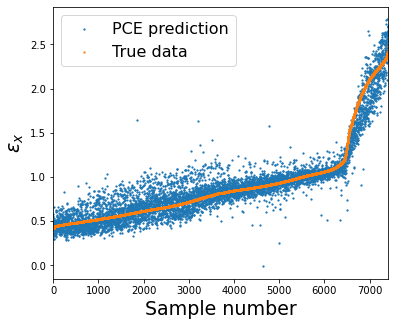

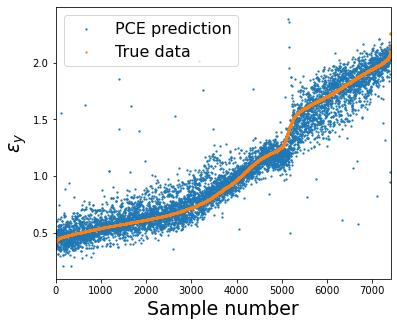

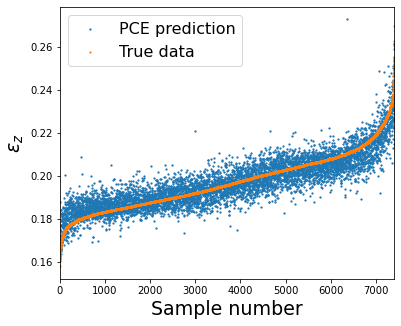

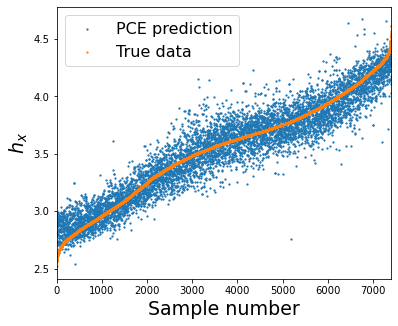

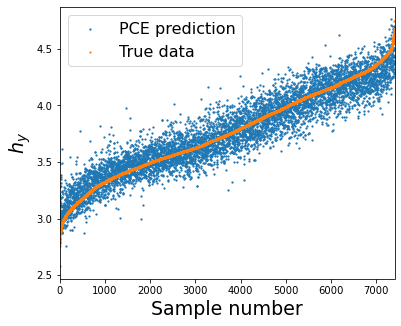

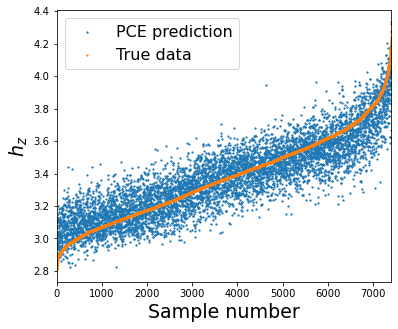

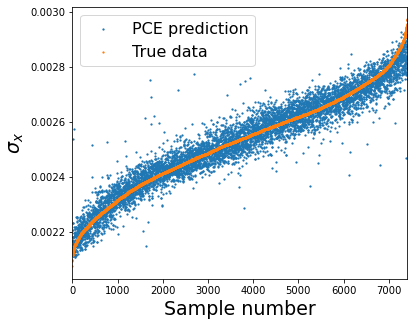

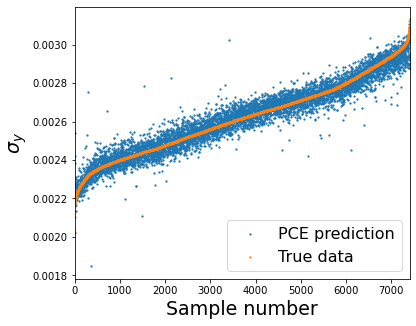

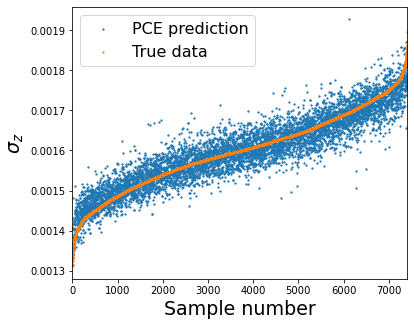

In [43]:
for i in range(len(y_sorted)):
    plt.figure(figsize=(6,5))
    plt.scatter(range(7406), y_sort_pred[i], s = 1.5)
    plt.scatter(range(7406), y_sorted[i], s = 1.5)
    plt.xlabel('Sample number', fontsize=19)
    plt.ylabel(labels[i], fontsize=19)
    plt.xlim(0,7406)
    plt.legend(['PCE prediction', 'True data'], fontsize=16)
    if save_figures:
        plt.savefig(fig_path + names_qoi[i] + '_sorted_pred.pdf', dpi=500, bbox_inches = "tight")
    plt.show()

-------------

## Compare $R^2$ and MAE test (%) with those for 1000 samples

In [44]:
full1 = np.load('./comparisons/1000_full.npy')
full2 = np.load('./comparisons/1500_full.npy')

In [45]:
r2_full = []

r2_full.append(full1[0][:9])
r2_full.append(full2[0][:9])
r2_full.append(Rsquared5)
r2_full.append(Rsquared6)

mae_full = []

mae_full.append(full1[1][:9])
mae_full.append(full2[1][:9])
mae_full.append(errors5['MAE test'].to_numpy())
mae_full.append(errors6['MAE test'].to_numpy())

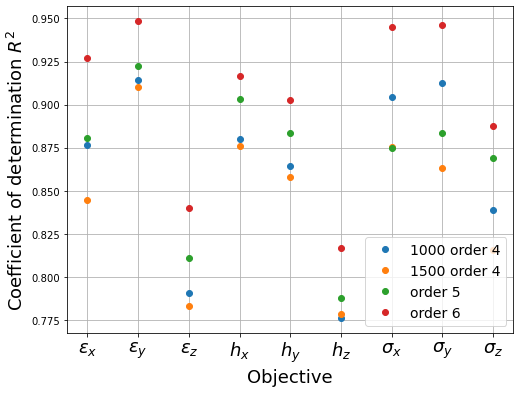

In [46]:
plt.figure(figsize=(8,6))
for r2 in r2_full:
    plt.plot(labels, r2, '.', markersize=12)
plt.xlabel('Objective', fontsize=18)
plt.ylabel('Coefficient of determination $R^2$', fontsize=18)
plt.legend(['1000 order 4','1500 order 4', 'order 5', 'order 6'], fontsize=14)
plt.xticks(fontsize=18)
plt.grid()
if save_figures:
    plt.savefig(fig_path + 'compare_r2.pdf', dpi=500, bbox_inches = "tight")
plt.show()

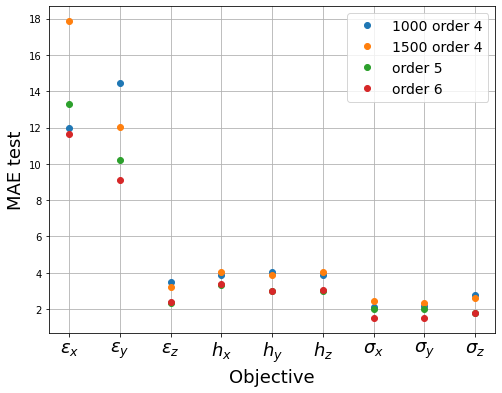

In [47]:
plt.figure(figsize=(8,6))
for mae in mae_full:
    plt.plot(labels, mae, '.', markersize=12)
plt.xlabel('Objective', fontsize=18)
plt.ylabel('MAE test', fontsize=18)
plt.legend(['1000 order 4','1500 order 4', 'order 5', 'order 6'], fontsize=14)
plt.xticks(fontsize=18)
plt.grid()
if save_figures:
    plt.savefig(fig_path + 'compare_mae.pdf', dpi=500, bbox_inches = "tight")
plt.show()

In [48]:
# Save R^2 and MAE test of order 6 with 7500 samples for later comparison (cf. 5000+1000+1000+500+2500.ipynb)

to_save = [Rsquared6, errors6['MAE test'].to_numpy()]
np.save('./comparisons/7500_full.npy', to_save)


## Compare fit with those for 1000 samples

In [49]:
from pyOPALTools.surrogate.load_uqtk import load_uq

model_dir = '/data/user/mayani_s/models/'
model_names = ['model_EMIT_X', 'model_EMIT_Y', 'model_EMIT_Z', 'model_HALO_X', 'model_HALO_Y', 'model_HALO_Z',
               'model_RMS_X','model_RMS_Y', 'model_RMS_Z', 'model_NUM_PART']

low_uq4 = []

for i in range(len(model_names)):
    low_uq4.append(load_uq(model_dir+model_names[i]+'.npy'))
    
xtrain_low = np.load('./xtrain.npy', allow_pickle=True)
ytrain_low = np.load('./ytrain.npy', allow_pickle=True)
xtest_low = np.load('./xtest.npy', allow_pickle=True)
ytest_low = np.load('./ytest.npy', allow_pickle=True)

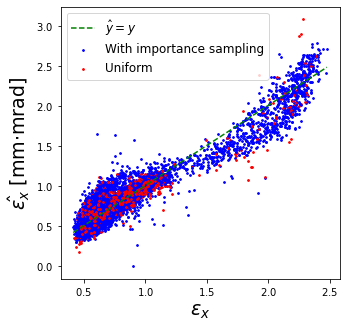

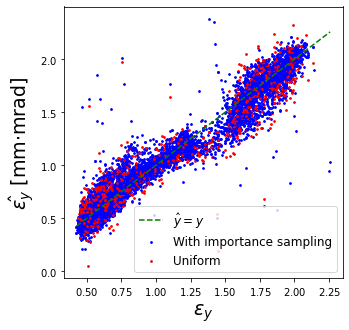

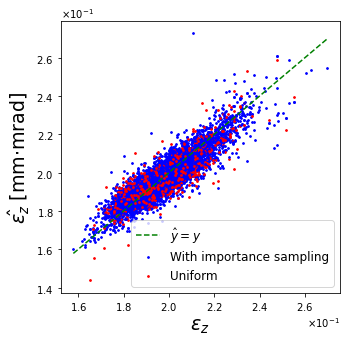

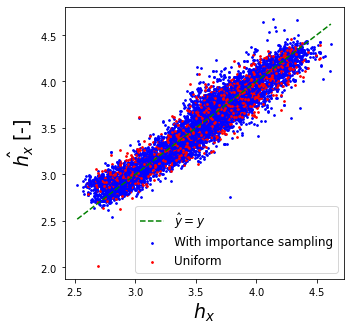

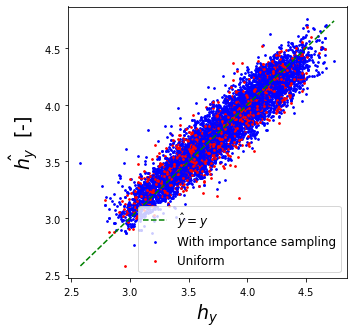

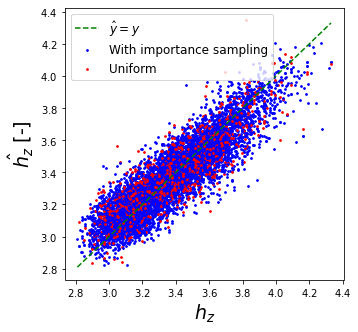

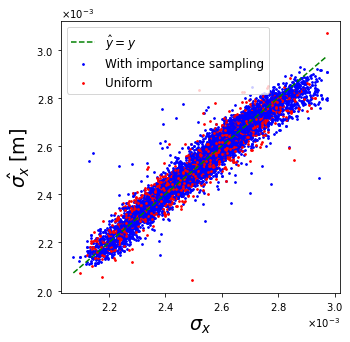

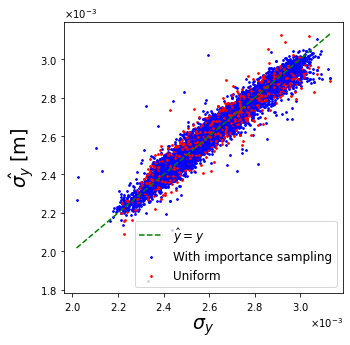

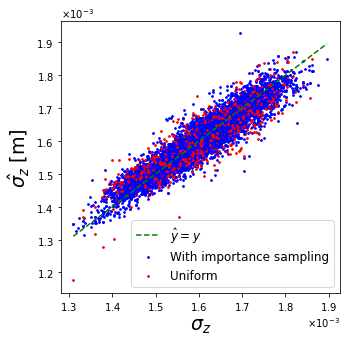

In [50]:
for i in range(len(ytrain)):
    plt.figure(figsize=(5,5))
    line = np.linspace(min(yunit[i]), max(yunit[i]), 10)
    plt.scatter(ytrain[i], yhat_train6[i], s=3, c='b')
    plt.scatter(ytrain_low[i], low_uq4[i].predict(xtrain_low[i]), s=3, c='r')
    plt.scatter(ytest[i], yhat_test6[i], s=3, c='b')
    plt.scatter(ytest_low[i], low_uq4[i].predict(xtest_low[i]), s=3, c='r')
    plt.xlabel(labels[i], fontsize=19)
    plt.ylabel(hat[i], fontsize=19)
    plt.ticklabel_format(axis='both', style='sci',scilimits=(0,0), useMathText=True)
    plt.plot(line, line, 'g--')
    plt.legend(['$\hat{y}=y$','With importance sampling', 'Uniform'], fontsize=12)
    if save_figures:
        plt.savefig(fig_path + names_qoi[i] + '_compare_fit.pdf', dpi=500, bbox_inches = "tight")
    plt.show()

## Observation: The MAE test and the $R^2$ values have improved, especially with order 6. The fit also looks very good for order 6. 

## The problem: do we attribute this improvement to the Importance Sampling or  just the general increase in sample size and therefore order? 

## Suggestion: Run a 7500 uniformly sampled sampler run, and compare results with this. If the fit is as good, then we can safely discard Importance Sampling as the reason. Therefore, we would be able to eliminate Importance Sampling as a path to take towards a better fit, and we can just increase the sample size and order.

## Indeed, it seems like if we go up to order 7, the emittance fits improve remarkably. For this, we would need $\approx$ 8500-9000 samples (as we can see here, with 7500 samples order 7 overfits, since testing error starts to increase then). 

## See 7500samples_2e4_16.ipynb.
